# Projeto preliminar de aeronave cargueira

Importar bibliotecas e conversões de unidades

In [2]:
%pip install ambiance

import numpy as np
from ambiance import Atmosphere
import json
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

Note: you may need to restart the kernel to use updated packages.


In [3]:
class units_class:
    def __init__():
        return

    def ft2m(ft):
        return 0.3048 * ft


    def lbf2n(lbf):
        return 4.4482 * lbf


    def lbm2kg(lbm):
        return 0.4536 * lbm


    def mi2m(mi):
        return  1609 * mi


    def in2m(inches):
        return 0.0254 * inches


    def knot2ms(knot):
        return 0.514 * knot


    def kgf2n(kgf):
        return 9.807 * kgf


    def slug2kg(slug):
        return 14.5939 * slug


    def knot2fts(knot):
        return 1.47 * knot


    def psi2Pa(psi):
        return 6894.76 * psi

    def hp2Watt(hp):
        return 745.69 * hp


units = units_class
g = 9.81
rho_SL = 1.225

# Importando dados do projeto conceitual

In [4]:
aircraft = {
   'definitions': {
  'MTOW': units.lbm2kg(19000), # Kg, assuming MTOW given by FAR23
  'V_cruise': units.knot2ms(230), # m/s, assuming CAS
  'W_empty/W': 0.6, # from database
  'W_crew': 200, # 2 pilots
  'operational ceiling': units.ft2m(25000),
   },
  'engine': {
    'power': units.hp2Watt(1600),
    'number_of_engines': 2,
    },
  'wing': {
    'b': 21,
    'CMA': 1.965,
    'S_wet': 84.4,
    'Percent_laminar': 0.1,
    'sweep': 0,
    'taper_ratio': 1,
    'hinge': False,
    'thickness': 0.12, 
    'material': "Aerospace aluminum", # Dever ser compativel com o arquivo weight_estimation_data.json
  },
  'ht': {
    'b': 6.5,
    'CMA': 1.491,
    'S_wet': 18.4,
    'Percent_laminar': 0.1,
    'sweep': 0,
    'taper_ratio': 1,
    'VH': 0.88, 
    'Ce_Ct': 0.4, 
    'hinge': True,
    'thickness': 0.12, 
    'material': "Aerospace aluminum", # Dever ser compativel com o arquivo weight_estimation_data.json
  },
  'vt': {
    'b': 2.75,
    'CMA': 2.156,
    'S_wet': 12.3,
    'Percent_laminar': 0.1,
    'sweep': 20,
    'taper_ratio': 1,
    'VV': 0.5, 
    'Cr_Cv': 0.4, 
    'hinge': True,
    'thickness': 0.12, 
    'material': "Aerospace aluminum", # Dever ser compativel com o arquivo weight_estimation_data.json
  },
  'fus': {
    'length': 18,
    'S_wet': 95.9,
    'diameter': 2.6,
    'Percent_laminar': 0,
    'material': "Aerospace aluminum", # Dever ser compativel com o arquivo weight_estimation_data.json
  },
  'landing gear': {
    'retractable': True,
    'height': 2.1, # Chutado
    },
}

# Calculo de peso vazio
aircraft['definitions']["W_empty"] = aircraft['definitions']["W_empty/W"] * aircraft['definitions']["MTOW"]
print(f'Peso vazio: {aircraft["definitions"]["W_empty"]}')

# Estimativa de carga alar, via linearização dos dados do banco de dados. É dada por Kg de MTOW/ Área de asa; deve ser convertido em N

aircraft['definitions']["wing_load"] = (0.00846 * aircraft['definitions']["MTOW"] + 121)*g
print(f'Carga alar: {aircraft["definitions"]["wing_load"]:.0f}')

# Projetando área para condição de cruzeiro, com consumo de combustível equivalente a 5% do peso total
aircraft['wing']["S"] = 0.95*aircraft["definitions"]["MTOW"] * g / aircraft["definitions"]["wing_load"]
print(f'Área de asa: {aircraft["wing"]["S"]:.1f}')

def estimate_aerodynamic_areas(aircraft):
    '''
    Estimate areas of aerodynamic surfaces based on the correlation between MTOW and areas of the cargo database
    '''
    # Parameter = MTOW

    x = aircraft['definitions']['MTOW']

    # horizontal tail

    aircraft['ht']['S'] = 4.3E-04*x + 6.03
    aircraft['ht']['S_elevator'] = 3.41E-04*x + 1.16

    aircraft['vt']['S'] = 4.77E-04*x + 2.57
    aircraft['vt']['S_rudder'] = 1.19E-04*x + 1.65

    aircraft['wing']['S_flap'] = 4.43E-04*x + 0.822
    aircraft['wing']['S_aileron'] = 1.8E-04*x + 1.63

    return aircraft

aircraft = estimate_aerodynamic_areas(aircraft)

print(f"""S_ref: {aircraft['wing']['S']:.3f}
S_Ht: {aircraft['ht']['S']:.3f}
S_profundor: {aircraft['ht']['S_elevator']:.3f}
S_Vt: {aircraft['vt']['S']:.3f}
S_leme: {aircraft['vt']['S_rudder']:.3f}
S_flap: {aircraft['wing']['S_flap']:.3f}
S_aileron: {aircraft['wing']['S_aileron']:.3f}
""")

aircraft['wing']['AR'] = aircraft['wing']['b']**2 / aircraft['wing']['S']
aircraft['ht']['AR'] = aircraft['ht']['b']**2 / aircraft['ht']['S']
aircraft['vt']['AR'] = aircraft['vt']['b']**2 / aircraft['vt']['S']

Peso vazio: 5171.04
Carga alar: 1902
Área de asa: 42.2
S_ref: 42.223
S_Ht: 9.736
S_profundor: 4.099
S_Vt: 6.681
S_leme: 2.676
S_flap: 4.640
S_aileron: 3.181



In [5]:
# Cálculos de peso conceituais

range = 0.0854*aircraft['definitions']["MTOW"] + 461

missao = {
    "Perfil" : ['Take off','Ascending','Cruise_1','Descending','Loitter','Cruise_2','Landing'],
    "Range_1" : units.mi2m(range),
    "Range_2" : units.mi2m(100),
    "Loitter_time" : 20 * 60
}

aircraft['missao'] = missao

# # Calculo de peso vazio
# aircraft['definitions']["W_empty"] = aircraft['definitions']["W_empty/W"] * aircraft['definitions']["MTOW"]
# print(f'Peso vazio: {aircraft["definitions"]["W_empty"]}')

# # Estimativa de carga alar, via linearização dos dados do banco de dados. É dada por Kg de MTOW/ Área de asa; deve ser convertido em N

# aircraft['definitions']["wing_load"] = (0.00846 * aircraft['definitions']["MTOW"] + 121)*g
# print(f'Carga alar: {aircraft["definitions"]["wing_load"]:.0f}')

# # Projetando área para condição de cruzeiro, com consumo de combustível equivalente a 5% do peso total
# aircraft['wing']["S"] = 0.95*aircraft["definitions"]["MTOW"] * g / aircraft["definitions"]["wing_load"]
# print(f'Área de asa: {aircraft["wing"]["S"]:.1f}')

# Definindo Cl para condição de cruzeiro
aircraft["definitions"]["Cl cruise"] = aircraft["definitions"]["wing_load"] / ( 0.5 * rho_SL * (aircraft["definitions"]["V_cruise"]**2 ) )
print(f'Cl de cruzeiro a nível do mar: {aircraft["definitions"]["Cl cruise"]:.2f}')

# Estimativa do empuxo necessário. Assume-se que, em cruzeiro, usa-se 65% da potência
# máxima do motor; eficiência da hélice de 80%; cálculo a nível do mar para projeto conceitual
power_cruise = 0.65 * aircraft["engine"]["power"]
eta = 0.65

aircraft['engine']["thrust cruise"] =  eta * power_cruise/ aircraft["definitions"]["V_cruise"]
aircraft["definitions"]["Thrust_to_weight"] =  aircraft["engine"]["thrust cruise"]/(aircraft["definitions"]["MTOW"]*g)
print(f'Empuxo do motor: {aircraft["engine"]["thrust cruise"]:.2f}')

aircraft["definitions"]["Cd cruise"] =  aircraft["engine"]["thrust cruise"]/(0.5 * rho_SL * (aircraft["definitions"]["V_cruise"]**2) * aircraft["wing"]["S"])
print(f'Cd de cruzeiro a nível do mar: {aircraft["definitions"]["Cd cruise"]:.4f}')
print(f'L/D de cruzeiro a nível do mar: {aircraft["definitions"]["Cl cruise"]/aircraft["definitions"]["Cd cruise"]:.2f}')

# Calculo do SFC em cruise e loiter a partir de Raymer
aircraft["engine"]['SFC_cruise'] = 0.5 * aircraft["definitions"]['V_cruise'] / (units.hp2Watt(550) * 0.8)
aircraft["engine"]['SFC_loiter'] = 0.6 * aircraft["definitions"]['V_cruise'] / (units.hp2Watt(550) * 0.8)
print(f'Consumo cruise : {aircraft["engine"]["SFC_cruise"]:e}')
print(f'Consumo loiter : {aircraft["engine"]["SFC_loiter"]:e}')

# Calculo de stall
aircraft["definitions"]['V_stall'] = np.sqrt(2*aircraft["definitions"]["MTOW"]*g/(rho_SL * aircraft['wing']['S'] * 2))


Cl de cruzeiro a nível do mar: 0.22
Empuxo do motor: 4263.97
Cd de cruzeiro a nível do mar: 0.0118
L/D de cruzeiro a nível do mar: 18.84
Consumo cruise : 1.801565e-04
Consumo loiter : 2.161878e-04


In [6]:
# Cálculo de pesos gerais

def first_weight_estimate(aircraft: dict) -> float :
    frac_weight = 1
    fracs = {
        'Take off':0.97,
        'Ascending':0.987,
        'Cruise_1':np.exp(-aircraft['missao']['Range_1'] * aircraft["engine"]["SFC_cruise"]/(aircraft["definitions"]['V_cruise'] * (aircraft["definitions"]["Cl cruise"]/aircraft["definitions"]["Cd cruise"]))),
        'Cruise_2':np.exp(-aircraft['missao']['Range_2'] * aircraft["engine"]["SFC_cruise"]/(aircraft["definitions"]['V_cruise'] * (aircraft["definitions"]["Cl cruise"]/aircraft["definitions"]["Cd cruise"]))),
        'Descending': 1,
        'Loitter': np.exp(-aircraft['missao']['Loitter_time'] * aircraft['engine']['SFC_loiter']/(aircraft["definitions"]["Cl cruise"]/aircraft["definitions"]["Cd cruise"])),
        'Landing': 0.995
    }

    print(fracs)

    for leg in aircraft['missao']['Perfil']:
        frac_weight = frac_weight * fracs[leg]

    return frac_weight

wf_frac = 1 - first_weight_estimate(aircraft)

print(wf_frac)

print(f'wf/w0= {wf_frac}')
print(f'wf = {wf_frac*aircraft["definitions"]["MTOW"]}')
print(f'vol = {wf_frac*aircraft["definitions"]["MTOW"]/0.72}')

aircraft['definitions']['W_fuel'] = wf_frac*aircraft["definitions"]["MTOW"]
aircraft['definitions']['W_payload'] = aircraft["definitions"]['MTOW'] * (1 - wf_frac - aircraft["definitions"]['W_empty/W']) - aircraft["definitions"]['W_crew']

w_pay = aircraft["definitions"]['MTOW'] * (1 - wf_frac - aircraft["definitions"]['W_empty/W']) - aircraft["definitions"]['W_crew']
print(f'Payload: {w_pay}')

aircraft['definitions']['WL'] = aircraft['definitions']['MTOW'] - 0.8 * wf_frac*aircraft["definitions"]["MTOW"] 
print(f'Wl: {aircraft["definitions"]["WL"]}')



{'Take off': 0.97, 'Ascending': 0.987, 'Cruise_1': 0.855717833036055, 'Cruise_2': 0.9870673858406859, 'Descending': 1, 'Loitter': 0.9863220797771163, 'Landing': 0.995}
0.20638821544149977
wf/w0= 0.20638821544149977
wf = 1778.7361959610216
vol = 2470.4669388347525
Payload: 1468.6238040389785
Wl: 7195.411043231183


In [7]:
# Cálculo de pesos específicos

with open(r"weight_estimation_data.json", "r") as file:
    weight_estimation_data = json.load(file)

print(weight_estimation_data.keys())

def calculate_wing_weight(aircraft, weight_estimation_data):
    """
    Estimate wing weight, based on geometry characteristics and statistical models from M. Saadrey, "Aircraft Design - Systems Engineers Approach (2012)"
    """
    SW = aircraft['wing']['S']
    MAC = aircraft['wing']['CMA']
    tC = aircraft['wing']['thickness']
    density = weight_estimation_data['engineering_materials']['Aerospace aluminum']['Density (kg/m^3)']
    AR = aircraft['wing']['AR']
    n_max = 2.5 # maximum load factor
    nult = 1.5 * n_max # Ultimate project load factor 
    sweep = aircraft['wing']['sweep']
    taper_ratio = aircraft['wing']['taper_ratio']

    K_p = min(weight_estimation_data["wing_structural_conditions"]["Transport, cargo, airliner (engines attached to the wing)"]['K_p'])

    W_w = (K_p * SW * MAC * (tC) * density * (AR * nult/np.cos(sweep))**0.6 * (taper_ratio)**0.04) * g
    return W_w

def calculate_horizontal_tail_weight(aircraft, weight_estimation_data):
    """
    Estimate wing weight, based on geometry characteristics and statistical models from M. Saadrey, "Aircraft Design - Systems Engineers Approach (2012)"
    """
    SHT = aircraft['ht']['S']
    MACHT = aircraft['ht']['CMA']
    tC_HT = aircraft['ht']['thickness']
    density = weight_estimation_data['engineering_materials']['Aerospace aluminum']['Density (kg/m^3)']
    ARHT = aircraft['ht']['AR']
    sweepHT = aircraft['ht']['sweep']
    taper_ratioHT = aircraft['ht']['taper_ratio']
    Ce_CT = aircraft['ht']['Ce_Ct']
    VH = aircraft['ht']['VH']
    g = 9.81

    K_HT = min(weight_estimation_data['tail_configurations']['Transport T-tail']['K_HT'])

    W_HT = (SHT * MACHT * tC_HT * density * K_HT * (ARHT / np.cos(sweepHT))**0.6 * taper_ratioHT**0.04 * VH**0.3 * Ce_CT**0.4) * g
    return W_HT

def calculate_vertical_tail_weight(aircraft, weight_estimation_data):
    """
    Estimate wing weight, based on geometry characteristics and statistical models from M. Saadrey, "Aircraft Design - Systems Engineers Approach (2012)"
    """
    SVT = aircraft['vt']['S']
    MACVT = aircraft['vt']['CMA']
    tC_VT = aircraft['vt']['thickness']
    density = weight_estimation_data['engineering_materials']['Aerospace aluminum']['Density (kg/m^3)']
    ARVT = aircraft['vt']['AR']
    sweepVT = aircraft['vt']['sweep']
    taper_ratioVT = aircraft['vt']['taper_ratio']
    Cr_Cv = aircraft['vt']['Cr_Cv']
    VV = aircraft['vt']['VV']
    g = 9.81

    K_VT = min(weight_estimation_data['tail_configurations']['Transport T-tail']['K_VT'])

    W_HT = (SVT * MACVT * tC_VT * density * K_VT * (ARVT / np.cos(sweepVT))**0.6 * taper_ratioVT**0.04 * VV**0.3 * Cr_Cv**0.4) * g
    return W_HT


def calculate_fuselage_weight(aircraft, weight_estimation_data):
    """
    Estimate wing weight, based on geometry characteristics and statistical models from M. Saadrey, "Aircraft Design - Systems Engineers Approach (2012)"
    """
    
    Lf = aircraft['fus']['length']
    D = aircraft['fus']['diameter']
    density = weight_estimation_data['engineering_materials']['Aerospace aluminum']['Density (kg/m^3)']
    Kpf = min(weight_estimation_data['kf_values']['Transport, cargo, airliner']['K_f'])
    g = 9.81
    
    K_inlet = 1 # no crew at transport section
    
    W_fus = Lf * D**2 * density * Kpf * K_inlet * g
    
    return W_fus


def calculate_landing_gear_weight(aircraft, weight_estimation_data):
    """
    Estimate wing weight, based on geometry characteristics and statistical models from M. Saadrey, "Aircraft Design - Systems Engineers Approach (2012)"
    """
    
    Kl = 1 # Don't need a aircraft carrier with hook
    if aircraft['landing gear']['retractable']:
        Kret = 1.07 
    else:
        Kret = 1
    Hlg = aircraft['landing gear']['height']
    b = aircraft['wing']['b']
    Wl = aircraft['definitions']['WL']
    n_max = 2.5 # maximum load factor
    nult = 1.5 * n_max # Ultimate project load factor 
    g = 9.81
    
    Klg = min(weight_estimation_data['klg_values']['Transport, cargo, airliner']['K_LG'])
    
    W_lg = Kl * Kret * Klg * Wl * Hlg / b * nult**0.2 * g
    
    return W_lg


def calculate_engine_weight(aircraft):
    """
    Estimate wing weight, based on geometry characteristics and statistical models from M. Saadrey, "Aircraft Design - Systems Engineers Approach (2012)"
    """
    
    W_e = aircraft['engine']['weight']
    N_e = aircraft['engine']['number_of_engines']
    K_e = 3 # SI units 
    g = 9.81
    
    W_e_ins = W_e**0.9 * K_e * N_e * g
    
    return W_e_ins


def calculate_fuel_weight(aircraft):
    """
    Estimate wing weight, based on geometry characteristics and statistical models from M. Saadrey, "Aircraft Design - Systems Engineers Approach (2012)"
    """
    
    if aircraft['engine']['number_of_engines']>1:
        Kfs = 4.5
        nfs = 0.6
    else:
        Kfs = 2
        nfs = 2/3
    
    g = 9.81
    
    W_f = aircraft['definitions']['W_fuel'] / units.lbm2kg(1) # W fuel in lb
    rho_f = 5.87 # lb/gal, aviation gas
    
    
    Wfs = Kfs * (W_f/rho_f)**nfs # lb
    
    return units.lbm2kg(Wfs) * g

aircraft['engine']['weight'] = 229.5

aircraft['wing']['W'] = calculate_wing_weight(aircraft, weight_estimation_data)
aircraft['ht']['W'] = calculate_horizontal_tail_weight(aircraft, weight_estimation_data)
aircraft['vt']['W'] = calculate_vertical_tail_weight(aircraft, weight_estimation_data)
aircraft['fus']['W'] = calculate_fuselage_weight(aircraft, weight_estimation_data)
W_fuel_system = calculate_fuel_weight(aircraft)
aircraft['engine']['W'] = calculate_engine_weight(aircraft)
aircraft['landing gear']['W'] = calculate_landing_gear_weight(aircraft, weight_estimation_data)

W_misc = (730/7650) * aircraft['definitions']['MTOW'] * 9.81 
# based on instruments weight for Beech 760

weights = []

for component in aircraft.keys():
    if component not in ['definitions', 'missao']:
        weights.append(aircraft[component]['W'])
        print(f'Component: {component}')
        print(f'Mass: {aircraft[component]["W"]/9.81:.1f} Kg')

weights.append(W_fuel_system)
weights.append(W_misc)
print('Componet: Fuel system')
print(f'Mass: {W_fuel_system/9.81:.1f} Kg')
print(f'Miscelanea mass: {W_misc/9.81:.1f} Kg')


masses = np.array(weights) / 9.81

We_final = sum(masses)

print(f'Total Empty weight mass: {We_final:.1f} Kg')
print(f'Empty weight + fuel: {aircraft["definitions"]["W_empty"] + aircraft["definitions"]["W_fuel"]:.1f} Kg')
print(f'MTOW estimated: {aircraft["definitions"]["MTOW"]} Kg')

dict_keys(['aircraft_data', 'aircraft_components', 'wing_data', 'wing_structural_conditions', 'engineering_materials', 'tail_configurations', 'kf_values', 'klg_values', 'engine_comparison', 'components_mass', 'aircraft_mtow_equipment'])
Component: engine
Mass: 799.6 Kg
Component: wing
Mass: 853.2 Kg
Component: ht
Mass: 167.2 Kg
Component: vt
Mass: 194.6 Kg
Component: fus
Mass: 824.7 Kg
Component: landing gear
Mass: 280.8 Kg
Componet: Fuel system
Mass: 101.1 Kg
Miscelanea mass: 822.4 Kg
Total Empty weight mass: 4043.6 Kg
Empty weight + fuel: 6949.8 Kg
MTOW estimated: 8618.4 Kg


# Trabalho 1 - Verificação de capacidade de recuperação da manobra parafuso

Estimativa de recuperação da manobra parafuso

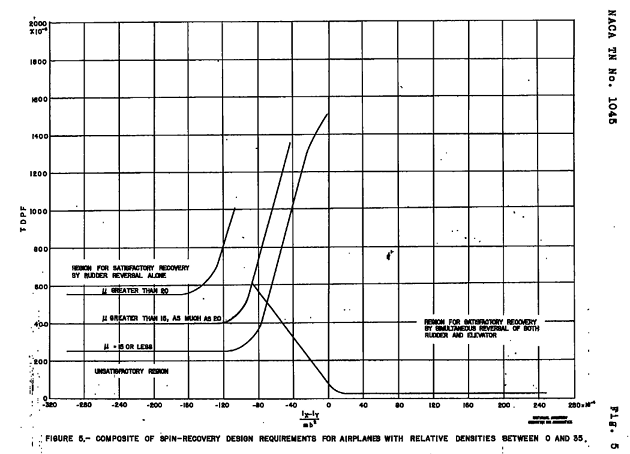

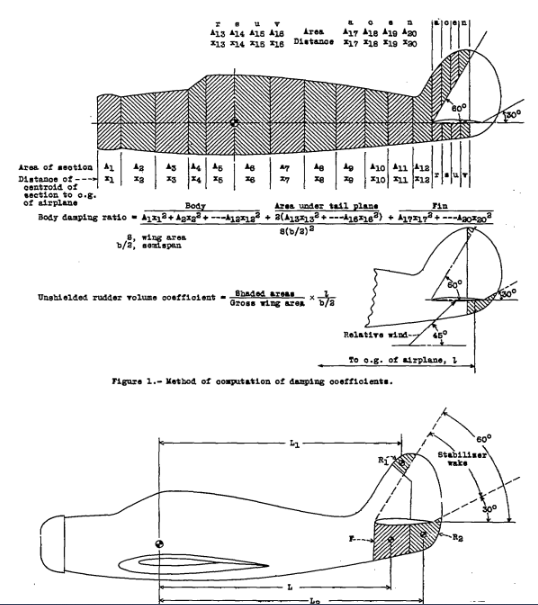

Metodologia exposta em NACA TN 1045 trata que, se o fator de potência de amortecimento de cauda, ou *tail-damping power factor*, a densidade relativa e a distribuição de massas se relacionarem de forma satisfatória, há grandes chances de recuperação do parafuso.

Quanto maior a distribuição de massa relativa, menor é a capacidade do amortecimento do EV de recuperar da manobra.



In [8]:
def mass_distribution(Ix, Iy, m, b):
    return (Ix-Iy)/(m*b**2)


def relative_density(W, S, rho, g, b):
    return W/(S*rho*g*g)


def compute_BDR(A, x, S, b):
    '''
    Body Damping Ratio
    '''

    Ax2 = sum(A*x**2)

    return Ax2/(S*(b/2)**2)


def compute_URVC(S_uns, l, S, b):
    '''
    Unshielded rudder volume coefficient

    S_uns = unshielded area
    l = distance between centroid of the unshielded rudder and aircraft CG
    '''

    return S_uns * l / (S*(b/2))


def compute_TDPF(URVC, BDR):
    '''
    Tail-damping power factor
    '''

    return URVC * BDR

rho = 1.225
Iz = 2*27455.3 # semelhante do Roskam
Ix = 2*20593.5 # semelhante do Roskam
m = units.lbm2kg(19000) # standard altitude for 15000 ft
g = 9.81
W = m*g
S = 42.2
b = 21
A = np.array([2.6*10.2, 1.9*(1.3 + 0.6)/2]) # Precisa do CAD
x = np.array([0.5, 7]) # Precisa do CAD
S_uns = 0.4 # Precisa do CAD
l = 7.6 # Precisa do CAD

mu = relative_density(W, S, rho, g, b)
PG = mass_distribution(Iz, Ix, m, b)
BDR = compute_BDR(A, x, S, b)
URVC = compute_URVC(S_uns, l, S, b)
TDPF = compute_TDPF(URVC, BDR)

print(f'Relative mass = {PG*1e4:.0f}e-4, TDPF ={TDPF*1e6:.0f}e-6, mu = {mu:.0f}')


Relative mass = 36e-4, TDPF =140e-6, mu = 17


# Trabalho 2 - dimensionamento de longarina

# Diagrama V-n preliminar

- Modelo de rajada:

\begin{equation}
    \Delta n = \dfrac{\rho V^2 S \Delta C_{za}}{2 W} = \dfrac{\rho V S \beta KU}{2 W}.
\end{equation}

Limitação no Vn por FAR23: 

- $n_{max}$ = 3.8
- $n_{min}$ = -0.4 $n_{max}$

In [9]:
def get_ku(condition):
    if condition == 'stall':
        return 50
    elif condition == 'cruise':
        return 40
    elif condition == 'dive':
        return 20
    else:
        print('Please, give a valid condition according to V-n diagram asked for FAR 23.333')
        return


def get_gusts_lines(cza, alphas, W, S, v, n_max, n_min, n_plus, n_minus):
    '''
    Return the arrays with values of lines with gusts to v_stall and v_dive
    
    Units:
    
    alphas: degree
    W: lbf
    S: ft²
    v: knots (mi/h)
    '''
    
    beta = (max(cza) - min(cza)) / (max(alphas)-min(alphas))
    
    # Stall
    
    ku_s = get_ku('stall')
    derivative_stall = 0.1 * beta * ku_s * S / W
    
    # positive
    
    vs_plus = v[n_plus!=n_max]
    delta_ns_plus =  derivative_stall * vs_plus
    n_sp = 1 + delta_ns_plus
    
    # negative
    
    vs_minus = v[n_minus!=n_min]
    delta_ns_minus = -derivative_stall * vs_minus  
    n_sm = delta_ns_minus
    
    # Dive
    
    ku_d = get_ku('dive')
    derivative_dive = 0.1 * beta * ku_d * S / W
    
    # positive
    
    delta_nd_plus = derivative_dive * v 
    n_dp = 1 + delta_nd_plus
    
    # negative
    
    delta_nd_minus = - derivative_dive *  v 
    n_dm = delta_nd_minus
    
    # cruise
    
    vc = v[-1] / 1.4
    vc_range = v[v<vc]
    ku_c = get_ku('cruise')
    derivative_cruise = 0.1 * beta * ku_c * S / W
    
    # Positive
    
    delta_nc_plus = derivative_cruise * vc_range 
    n_cp = 1 + delta_nc_plus
    
    # Negative
    
    delta_nc_minus = -derivative_cruise * vc_range 
    n_cm = delta_nc_minus
    
    return n_sp, n_sm, n_dp, n_dm, n_cp, n_cm, derivative_stall, derivative_dive, derivative_cruise

In [10]:
# Problem data

n_max = 3.8
n_min = -0.4 * n_max

W = aircraft['definitions']['MTOW'] * g / units.kgf2n(1) # lbf
S = aircraft['wing']['S'] / (units.ft2m(1)**2) # ft²
rho = 0.00238 # slugs/ft³

Vc = aircraft['definitions']['V_cruise'] / units.knot2ms(1)  # mi/h
Vd = int(1.4*Vc)
cza = np.array([-1, -0.6, -0.3, 0.1, 0.5, 1, 1.4, 1.8, 2])
alpha = np.array([-15, -10, -5, 0, 5, 10, 15, 20, 25])

v = np.linspace(0, Vd, Vd+1)

# Get the envelope of maneuvering

# Stall

# Positive n

v_ft = units.knot2fts(v)

n_plus = max(cza) * rho * S * np.power(v_ft, 2) / 2 / W
OA = n_plus[n_plus <= n_max]

# Negative n

n_minus = min(cza) * rho * S * np.power(v_ft, 2) / 2 / W
OB = n_minus[n_minus >= n_min]

# After the stall

n_plus[n_plus>n_max] = n_max
n_minus[n_minus<n_min] = n_min

n_plus = np.concatenate((OA, n_plus[n_plus==n_max]), axis=None)
n_minus = np.concatenate((OB, n_minus[n_minus==n_min]), axis=None)

# gusts calculus

[gust_stall_plus, gust_stall_minus, gust_dive_plus, gust_dive_minus, gust_cruise_plus, gust_cruise_minus, 
 a_stall, a_dive, a_cruise] = get_gusts_lines(cza, alpha, W, S, v, n_max, n_min, n_plus, n_minus)

v_gust_stall_plus = v[n_plus!=n_max]
v_gust_stall_minus = v[n_minus!=n_min]

v_gust_cruise = v[v<Vd/1.4]

Text(307.0, -1.72, 'D')

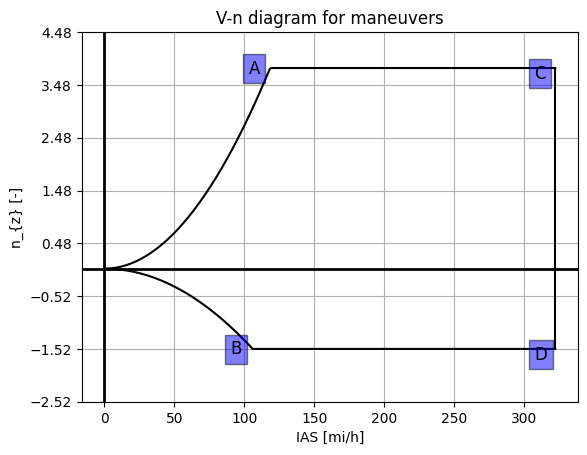

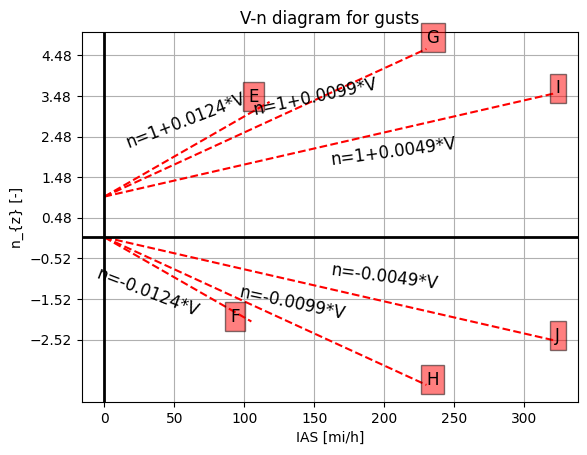

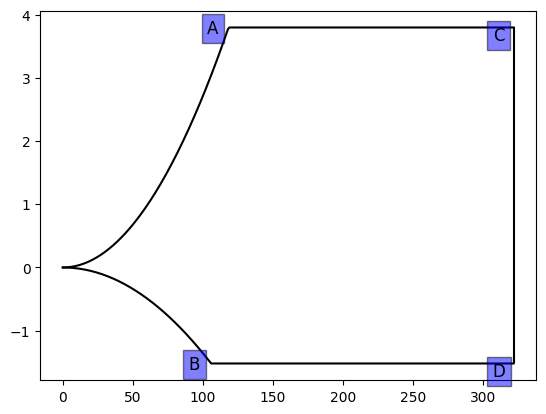

In [11]:
# Visualization

## Maneuver

plt.figure()

plt.plot(v, n_plus, color = 'black')
plt.plot(v, n_minus, color = 'black') 
plt.vlines(x=Vd, ymin = n_min, ymax = n_max, colors = 'black')

plt.text(max(v_gust_stall_plus)-15, n_max-0.1, 'A', size='large', bbox=dict(facecolor='blue', alpha=0.5))
plt.text(max(v_gust_stall_minus)-15, n_min-0.1, 'B', size='large', bbox=dict(facecolor='blue', alpha=0.5))
plt.text(max(v)-15, n_max-0.2, 'C', size='large', bbox=dict(facecolor='blue', alpha=0.5))
plt.text(max(v)-15, n_min-0.2, 'D', size='large', bbox=dict(facecolor='blue', alpha=0.5))

plt.xlabel('IAS [mi/h]')
plt.ylabel('n_{z} [-]')
plt.title('V-n diagram for maneuvers')
plt.axhline(linewidth=2, color='k')
plt.axvline(linewidth=2, color='k')
plt.yticks(np.arange(n_min-1, n_max+1, 1.0))
plt.grid()

## Gusts

plt.figure()

plt.plot(v_gust_stall_plus, gust_stall_plus, color='red', linestyle='--')
plt.plot(v_gust_stall_minus, gust_stall_minus, color='red', linestyle='--')
plt.plot(v, gust_dive_plus, color='red', linestyle='--')
plt.plot(v, gust_dive_minus, color='red', linestyle='--')
plt.plot(v_gust_cruise, gust_cruise_plus, color='red', linestyle='--')
plt.plot(v_gust_cruise, gust_cruise_minus, color='red', linestyle='--')

plt.text(max(v_gust_stall_plus)-15, max(gust_stall_plus), 'E', size='large', bbox=dict(facecolor='red', alpha=0.5))
plt.text(np.mean(v_gust_stall_plus)-45, np.mean(gust_stall_plus)+0.05, 'n=1+0.0124*V', size='large', 
         rotation=21)
plt.text(max(v_gust_stall_minus)-15, min(gust_stall_minus), 'F', size='large', bbox=dict(facecolor='red', alpha=0.5))
plt.text(np.mean(v_gust_stall_minus)-60, np.mean(gust_stall_minus)-0.9, 'n=-0.0124*V', size='large', 
         rotation=-21)

plt.text(max(v_gust_cruise), max(gust_cruise_plus)+0.15, 'G', size='large', bbox=dict(facecolor='red', alpha=0.5))
plt.text(np.mean(v_gust_cruise)-10, np.mean(gust_cruise_plus)+0.2, 'n=1+0.0099*V', size='large', 
         rotation=12)
plt.text(max(v_gust_cruise), min(gust_cruise_minus), 'H', size='large', bbox=dict(facecolor='red', alpha=0.5))
plt.text(np.mean(v_gust_cruise)-20, np.mean(gust_cruise_minus)-0.2, 'n=-0.0099*V', size='large', 
         rotation=-12)

plt.text(max(v), max(gust_dive_plus), 'I', size='large', bbox=dict(facecolor='red', alpha=0.5))
plt.text(np.mean(v), np.mean(gust_dive_plus)-0.5, 'n=1+0.0049*V', size='large', 
         rotation=7.5)
plt.text(max(v), min(gust_dive_minus), 'J', size='large', bbox=dict(facecolor='red', alpha=0.5))
plt.text(np.mean(v), np.mean(gust_dive_minus), 'n=-0.0049*V', size='large', 
         rotation=-7.5)


plt.xlabel('IAS [mi/h]')
plt.ylabel('n_{z} [-]')
plt.title('V-n diagram for gusts')
plt.axhline(linewidth=2, color='k')
plt.axvline(linewidth=2, color='k')
plt.yticks(np.arange(n_min-1, n_max+1, 1.0))
plt.grid() 


## Sketch of total V-n

plt.figure()

# Maneuver

plt.plot(v, n_plus, color = 'black')
plt.plot(v, n_minus, color = 'black') 
plt.vlines(x=Vd, ymin = n_min, ymax = n_max, colors = 'black')


plt.text(max(v_gust_stall_plus)-15, n_max-0.1, 'A', size='large', bbox=dict(facecolor='blue', alpha=0.5))
plt.text(max(v_gust_stall_minus)-15, n_min-0.1, 'B', size='large', bbox=dict(facecolor='blue', alpha=0.5))
plt.text(max(v)-15, n_max-0.2, 'C', size='large', bbox=dict(facecolor='blue', alpha=0.5))
plt.text(max(v)-15, n_min-0.2, 'D', size='large', bbox=dict(facecolor='blue', alpha=0.5))

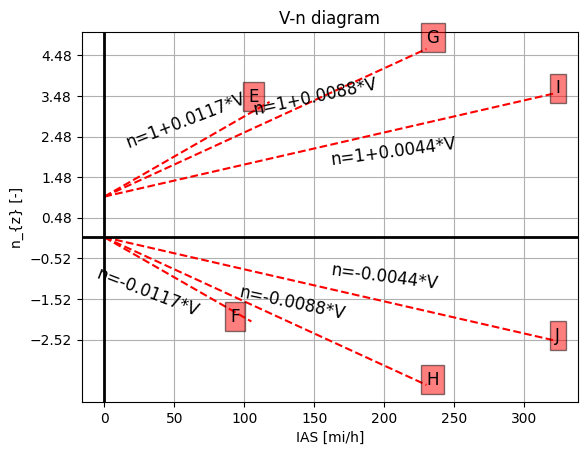

In [12]:
# Gusts

plt.plot(v_gust_stall_plus, gust_stall_plus, color='red', linestyle='--')
plt.plot(v_gust_stall_minus, gust_stall_minus, color='red', linestyle='--')
plt.plot(v, gust_dive_plus, color='red', linestyle='--')
plt.plot(v, gust_dive_minus, color='red', linestyle='--')
plt.plot(v_gust_cruise, gust_cruise_plus, color='red', linestyle='--')
plt.plot(v_gust_cruise, gust_cruise_minus, color='red', linestyle='--')

plt.text(max(v_gust_stall_plus)-15, max(gust_stall_plus), 'E', size='large', bbox=dict(facecolor='red', alpha=0.5))
plt.text(np.mean(v_gust_stall_plus)-45, np.mean(gust_stall_plus)+0.05, 'n=1+0.0117*V', size='large', 
         rotation=21)
plt.text(max(v_gust_stall_minus)-15, min(gust_stall_minus), 'F', size='large', bbox=dict(facecolor='red', alpha=0.5))
plt.text(np.mean(v_gust_stall_minus)-60, np.mean(gust_stall_minus)-0.9, 'n=-0.0117*V', size='large', 
         rotation=-21)

plt.text(max(v_gust_cruise), max(gust_cruise_plus)+0.15, 'G', size='large', bbox=dict(facecolor='red', alpha=0.5))
plt.text(np.mean(v_gust_cruise)-10, np.mean(gust_cruise_plus)+0.2, 'n=1+0.0088*V', size='large', 
         rotation=12)
plt.text(max(v_gust_cruise), min(gust_cruise_minus), 'H', size='large', bbox=dict(facecolor='red', alpha=0.5))
plt.text(np.mean(v_gust_cruise)-20, np.mean(gust_cruise_minus)-0.2, 'n=-0.0088*V', size='large', 
         rotation=-12)

plt.text(max(v), max(gust_dive_plus), 'I', size='large', bbox=dict(facecolor='red', alpha=0.5))
plt.text(np.mean(v), np.mean(gust_dive_plus)-0.5, 'n=1+0.0044*V', size='large', 
         rotation=7.5)
plt.text(max(v), min(gust_dive_minus), 'J', size='large', bbox=dict(facecolor='red', alpha=0.5))
plt.text(np.mean(v), np.mean(gust_dive_minus), 'n=-0.0044*V', size='large', 
         rotation=-7.5)


plt.xlabel('IAS [mi/h]')
plt.ylabel('n_{z} [-]')
plt.title('V-n diagram')
plt.axhline(linewidth=2, color='k')
plt.axvline(linewidth=2, color='k')
plt.yticks(np.arange(n_min-1, n_max+1, 1.0))
plt.grid()

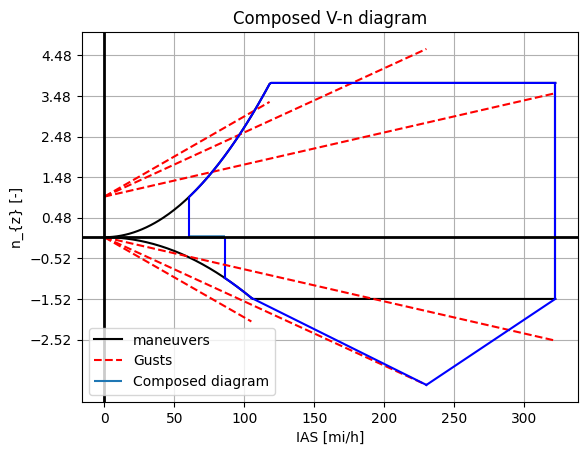

In [13]:
## Final total V-n

plt.figure()

# Maneuver

plt.plot(v, n_plus, color = 'black', label='maneuvers')
plt.plot(v[n_minus>=n_min], n_minus[n_minus>= n_min], color = 'black') 
plt.vlines(x=Vd, ymin = n_min, ymax = n_max, colors = 'black')

linear_interp_positive = interp1d([n_plus[n_plus<=1][-1], n_plus[n_plus>=1][0]], 
                                  [[v[n_plus<=1][-1], v[n_plus>=1][0]]])

plt.vlines(x=linear_interp_positive(1), ymin = 0, ymax = 1, colors='blue')

linear_interp_negative = interp1d([n_minus[n_minus>=-1][-1], n_minus[n_minus<=-1][0]], 
                                  [v[n_minus>=-1][-1], v[n_minus<=-1][0]])

plt.vlines(x=linear_interp_negative(-1), ymin=-1, ymax=0, colors='blue')

plt.plot(v_gust_stall_plus, gust_stall_plus, color='red', linestyle='--')
plt.plot(v_gust_stall_minus, gust_stall_minus, color='red', linestyle='--')
plt.plot(v, gust_dive_plus, color='red', linestyle='--')
plt.plot(v, gust_dive_minus, color='red', linestyle='--')
plt.plot(v_gust_cruise, gust_cruise_plus, color='red', linestyle='--')
plt.plot(v_gust_cruise, gust_cruise_minus, color='red', linestyle='--', label='Gusts')


v_aux = v[n_minus>n_min]
n_aux = n_minus[n_minus>n_min]
n_resultant_negative = n_aux[n_aux<=-1]
v_resultant_negative = v_aux[n_aux<=-1]

plt.plot(v[n_plus>=1], n_plus[n_plus>=1], color = 'blue')
plt.plot(v_resultant_negative, n_resultant_negative, color = 'blue')
plt.vlines(x=Vd, ymin = n_min, ymax = n_max, colors = 'blue')
plt.hlines(y=np.zeros((len(v[n_plus>=1]) - len(v[n_minus<=-1]))), xmin=v[n_minus<=-1][0], xmax=v[n_plus>=1][0], 
           label='Composed diagram')
plt.plot([v_resultant_negative[-1], v_gust_cruise[-1]], [n_resultant_negative[-1],gust_cruise_minus[-1]], 
         color= 'blue')
plt.plot([v_gust_cruise[-1],v[-1]], [gust_cruise_minus[-1],n_min],
         color= 'blue')

plt.xlabel('IAS [mi/h]')
plt.ylabel('n_{z} [-]')
plt.title('Composed V-n diagram')
plt.axhline(linewidth=2, color='k')
plt.axvline(linewidth=2, color='k')
plt.yticks(np.arange(n_min-1, n_max+1, 1.0))
plt.grid()
plt.legend()
plt.show()

# Cálculo de distribuição de sustentação

## Método de Anderson & Pearson

Consiste em dividir a asa em seções, calcular o parÂmetro Cla1 para cada uma delas, e relacionar com o Clb (calculado para a Asa).

$C_{lb} = \frac{ϵ  a_{e}  S}{c  b} L_b$
(no nosso caso é 0)

$C_{la1} = \frac{S}{c  b} L_a$

De modo que o Cl de cada seção seja calculado por

$C_l = C_{lb} + C_L C_{la1}$

[12.33538097 12.26929857 12.11510631 11.58644712  9.96742837  7.96292896
  6.33289648  4.82401506]


Text(0, 0.5, 'Cl')

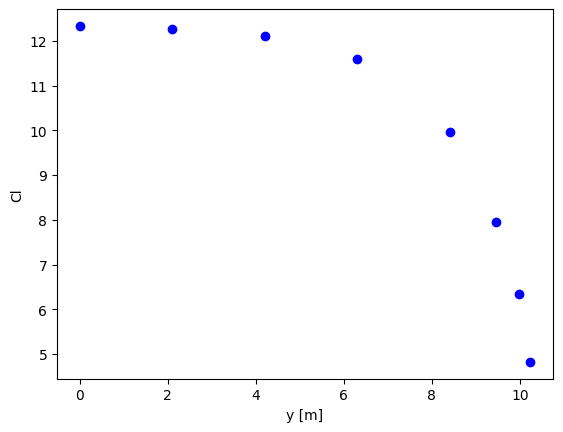

In [14]:
#numero de seções = 8
y = np.array([0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.975])
afil = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
#Matriz onde cada linha é uma posição na envergadura conforme vetor y e cada coluna é um afilamento
La = np.matrix([[1.661, 1.558, 1.473, 1.409, 1.355, 1.306, 1.264, 1.222, 1.187, 1.152, 1.120],
      [1.513, 1.411, 1.347, 1.299, 1.265, 1.236, 1.209, 1.182, 1.158, 1.137, 1.114],
      [1.228, 1.192, 1.167, 1.148, 1.132, 1.121, 1.113, 1.108, 1.104, 1.102, 1.100],
      [0.881, 0.907, 0.929, 0.947, 0.961, 0.976, 0.992, 1.008, 1.023, 1.039, 1.052],
      [0.486, 0.585, 0.653, 0.704, 0.748, 0.783, 0.815, 0.842, 0.868, 0.887, 0.905],
      [0.266, 0.383, 0.472, 0.541, 0.590, 0.628, 0.656, 0.679, 0.698, 0.712, 0.723],
      [0.138, 0.255, 0.346, 0.410, 0.460, 0.495, 0.520, 0.538, 0.553, 0.566, 0.575],
      [0.069, 0.158, 0.233, 0.295, 0.343, 0.373, 0.390, 0.403, 0.415, 0.428, 0.438]])

CL = 2.1
c = 1.965
Cla1 = np.zeros(8)
j_afil = 10
i=0
while i<8:
  Cla1[i] = S/(c*b) * La[i,j_afil]
  i += 1

print(Cla1)
plt.plot(y*b/2, Cla1, 'bo')
plt.xlabel('y [m]')
plt.ylabel('Cl')


## Método de Schrenk

Consiste em obter a distribuição de sustentação a partir da média entre a distribuição de corda real e a distribuição elíptica, de mesma envergadura e área que a verdadeira. 

\begin{align}
L'_{\text{elliptical}} &= qC_l \left(\frac{4S}{\pi b} \sqrt{1 - \left( \frac{2y}{b} \right)^2} \tag{2-1}\right) \\
L'_{\text{planform}} &= qC_l \left(\frac{2S}{(1 + \lambda) b} \left( 1 + \frac{2y}{b} (\lambda - 1) \right) \tag{2-2}\right) \\
L'_{\text{schrenk}} &= \frac{L'_{\text{elliptical}} + L'_{\text{planform}}}{2} \tag{2-3}
\end{align}

with 

\begin{align}
L &: \text{total lift force (N)} \\
L' &: \text{lift distribution (N/m)}
\end{align}

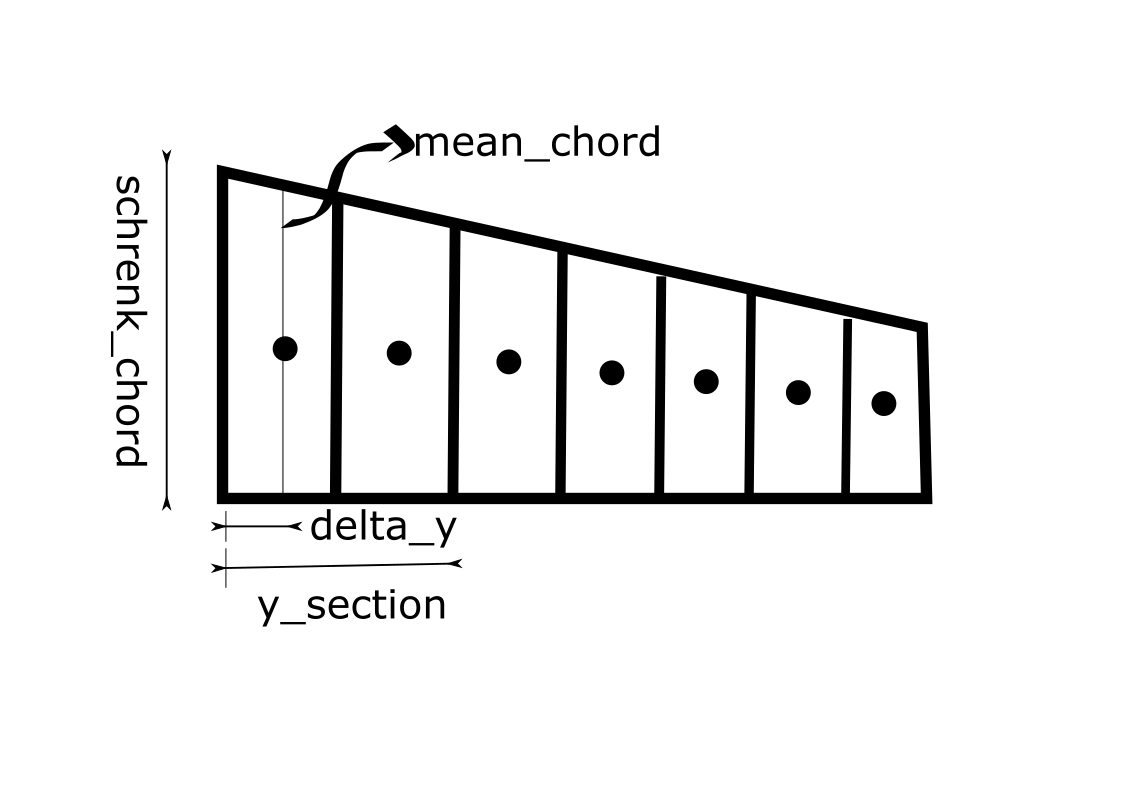

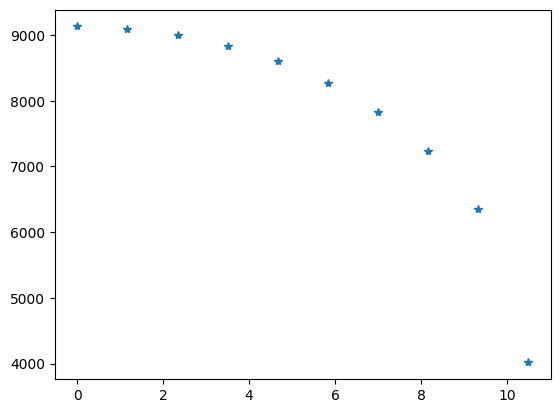

In [15]:
# Schrenk

def schrenk_method_chord(S, b, afil, y_sections):

    # Elliptical

    chord_elliptical = 4*S/np.pi/b * np.sqrt(1 - (2*y_sections/b)**2)

    # trapezoidal

    chord_trapezoidal = 2*S / ( (1+afil) * b ) * ( 1 + 2/b * y_sections * (afil - 1) )

    return (chord_elliptical + chord_trapezoidal)/2

y_sections = np.linspace(0, aircraft['wing']['b']/2, 10)

schrenk_chord = schrenk_method_chord(aircraft['wing']['S'], aircraft['wing']['b'], 
                                     aircraft['wing']['taper_ratio'], y_sections)

q = 0.5 * rho_SL * aircraft['definitions']['V_cruise']**2
Cl = 2.1
wing_load = aircraft['definitions']['wing_load']

# L_distribution = q*schrenk_chord*Cl
L_distribution = wing_load*schrenk_chord*Cl

plt.plot(y_sections, L_distribution, '*')

In [16]:
y_sections

array([ 0.        ,  1.16666667,  2.33333333,  3.5       ,  4.66666667,
        5.83333333,  7.        ,  8.16666667,  9.33333333, 10.5       ])

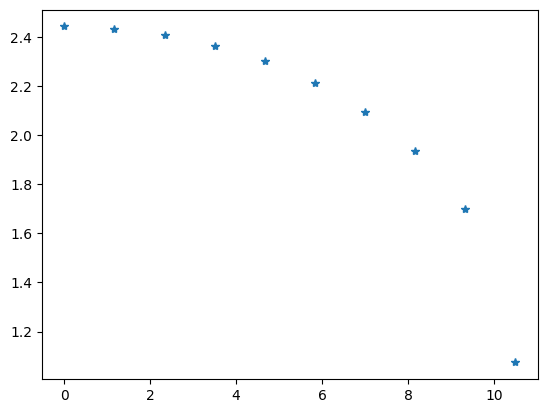

In [17]:
delta_y = np.diff(y_sections)
mean_chord = np.array([(a + b) / 2 for a, b in zip(schrenk_chord[::1], schrenk_chord[1::1])])

w = wing_load*Cl*mean_chord * delta_y

Cl_local = schrenk_chord * Cl / aircraft['wing']['CMA']

plt.plot(y_sections, Cl_local, '*')

# Cálculo dos carregamentos sobre a asa

\begin{align}
S.F &= \int_0^{b/2} w \, dy = \sum_{i=1}^{i=n} \left( \frac{w_1 + w_2}{2} \right) \Delta y \\
B.M &= \int_0^{b/2} S.F \, dy = \iint_0^{b/2} w \, dy = \sum_{i=1}^{i=n} \left( \frac{S.F_1 + S.F_2}{2} \right) \Delta y
\end{align}


In [36]:
SF = w * delta_y
len(w)

for i in np.arange(len(SF)):
    print(i)

0
1
2
3
4
5
6
7
8


In [49]:
np.flip(y_sections[0:-1])

array([9.33333333, 8.16666667, 7.        , 5.83333333, 4.66666667,
       3.5       , 2.33333333, 1.16666667, 0.        ])

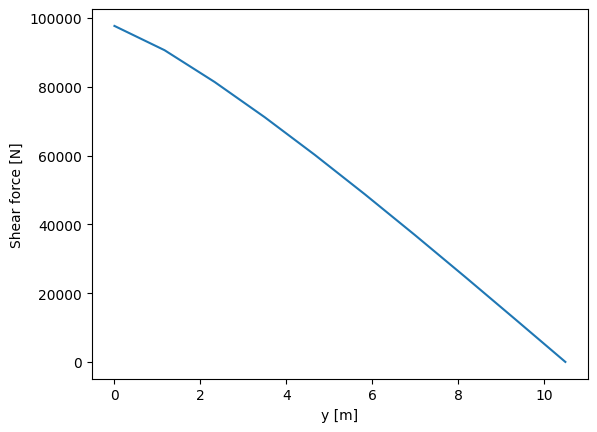

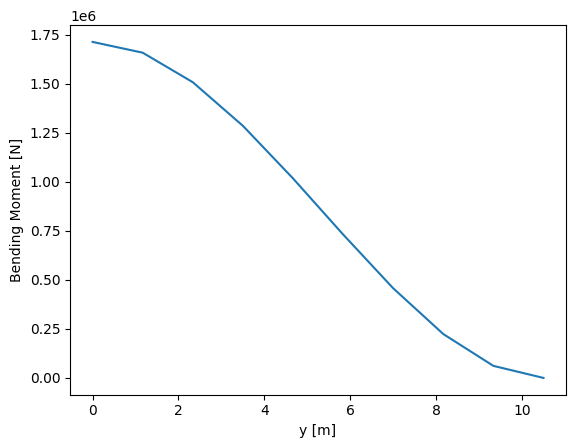

In [59]:
def compute_shear_force_and_bending_moment(w, delta_y, y_sections):
    # delta_w = np.array([(a + b) / 2 for a, b in zip(w[::1], w[1::1])])

    SF = np.zeros((len(w)+1))
    SF[0] = 0
    SF_local = w * delta_y
    for i in np.arange(len(SF_local)):
        SF[i+1] = SF[i] + SF_local[i]

    mean_SF = np.array([(a + b) / 2 for a, b in zip(SF[::1], SF[1::1])])

    y_prime = np.flip(y_sections[0:-1]) + delta_y/2 # considerando delta_y cte 

    BM = np.zeros((len(w)+1))
    BM[0] = 0
    BM_local = y_prime * mean_SF
    # BM[1:] = BM_local
    for i in np.arange(len(BM_local)):
        BM[i+1] = BM[i] + BM_local[i]

    return SF, BM


SF, BM = compute_shear_force_and_bending_moment(w, delta_y, y_sections)

plt.plot(y_sections, np.flip(SF))
plt.xlabel('y [m]')
plt.ylabel('Shear force [N]')
plt.show()

plt.plot(y_sections, np.flip(BM))
plt.xlabel('y [m]')
plt.ylabel('Bending Moment [N]')
plt.show()

# Dimensionamento da espessura da longarina

# Dimensionamento da fuselagem